## 1. Setup & Dependencies

In [1]:

import os

# 1. Clone the repository
!git clone https://github.com/Zaharah/processtransformer.git
%cd processtransformer

# 2. Install the legacy Keras shim (Critical for Colab's new TensorFlow)
!pip install tf_keras

# 3. Install the project itself (skips strict TF version check)
!pip install .

# 4. Set the environment variable to force Legacy Keras behavior
# This mimics TF 2.x behavior so the old code runs without errors.
os.environ["TF_USE_LEGACY_KERAS"] = "1"

print("✅ Environment Ready. Legacy Keras enabled.")

Cloning into 'processtransformer'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 82 (delta 15), reused 7 (delta 7), pack-reused 60 (from 1)
Receiving objects: 100% (82/82), 160.91 KiB | 1.28 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/processtransformer
Processing /content/processtransformer
  Preparing metadata (setup.py) ... done
  Created wheel for processtransformer: filename=processtransformer-0.1.3-py3-none-any.whl size=12361 sha256=f1597979532781b20394e46697a2fad14ab311e7fcb13c73f6ae0bc2f363a1f4
  Stored in directory: /tmp/pip-ephem-wheel-cache-ebvhpz50/wheels/0a/8c/d4/1abdf86841e5ed023b6f80c5c7ff7bb1c287d3bfcccbf7b49d
Successfully built processtransformer
✅ Environment Ready. Legacy Keras enabled.


In [ ]:
# !pip install tensorflow==2.15.0
# !pip install pm4py
# !pip install huggingface_hub
# !pip install scikit-learn

# # Clone ProcessTransformer repository
# !git clone https://github.com/Zaharah/processtransformer.git
# %cd processtransformer

In [13]:
# HF Access
!pip install huggingface_hub transformers -q

from google.colab import userdata
from huggingface_hub import login

# Access the secret you created
token = userdata.get('HF_TOKEN')

# Login with the write permissions
login(token)

## 2. Data Loading



In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Create working directory
import os
WORK_DIR = '/content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer'
os.makedirs(WORK_DIR, exist_ok=True)
os.makedirs(f'{WORK_DIR}/data', exist_ok=True)
os.makedirs(f'{WORK_DIR}/models', exist_ok=True)

Mounted at /content/drive


In [3]:
DATA_PATH = f'{WORK_DIR}/data/bpic17_pt.csv'

## 3. Data Preprocessing


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import json

# Load data
df = pd.read_csv(DATA_PATH)
print(f"Loaded: {len(df)} events, {df['Case ID'].nunique()} cases")

# Build vocabulary
activities = df['Activity'].unique().tolist()
activities = ['<PAD>', '<START>', '<END>'] + sorted(activities)  # Special tokens

activity_to_idx = {act: idx for idx, act in enumerate(activities)}
idx_to_activity = {idx: act for act, idx in activity_to_idx.items()}

vocab_size = len(activities)
print(f"Vocabulary size: {vocab_size}")

# Save vocabulary
vocab_path = f'{WORK_DIR}/models/vocab.json'
with open(vocab_path, 'w') as f:
    json.dump({
        'activity_to_idx': activity_to_idx,
        'idx_to_activity': {str(k): v for k, v in idx_to_activity.items()},
        'vocab_size': vocab_size,
    }, f, indent=2)
print(f"Saved vocabulary to: {vocab_path}")

# Convert activities to indices
df['activity_idx'] = df['Activity'].map(activity_to_idx)

# Group by case and create sequences
cases = df.groupby('Case ID')['activity_idx'].apply(list).reset_index()
cases.columns = ['case_id', 'sequence']

# Calculate max case length
max_case_length = cases['sequence'].apply(len).max()
print(f"Max case length: {max_case_length}")

# Use reasonable max length (cap at 100 for memory)
MAX_SEQ_LEN = min(max_case_length + 2, 100)  # +2 for START/END tokens
print(f"Using max sequence length: {MAX_SEQ_LEN}")

# Create training examples (prefix → next activity)
def create_training_examples(sequences, max_len):
    """Generate prefix-target pairs for each case."""
    X, y = [], []
    start_idx = activity_to_idx['<START>']
    end_idx = activity_to_idx['<END>']
    pad_idx = activity_to_idx['<PAD>']

    for seq in sequences:
        # Add START token at beginning
        full_seq = [start_idx] + seq + [end_idx]

        # Generate prefixes of increasing length
        for i in range(1, len(full_seq)):
            prefix = full_seq[:i]
            target = full_seq[i]

            # Pad prefix to max length
            if len(prefix) < max_len:
                prefix = [pad_idx] * (max_len - len(prefix)) + prefix
            else:
                prefix = prefix[-max_len:]  # Take last max_len tokens

            X.append(prefix)
            y.append(target)

    return np.array(X), np.array(y)

X, y = create_training_examples(cases['sequence'].tolist(), MAX_SEQ_LEN)
print(f"Training examples: {len(X)}")

# Train/validation split (by case, not by example)
train_cases, val_cases = train_test_split(
    cases['sequence'].tolist(),
    test_size=0.2,
    random_state=42
)

X_train, y_train = create_training_examples(train_cases, MAX_SEQ_LEN)
X_val, y_val = create_training_examples(val_cases, MAX_SEQ_LEN)

print(f"Training: {len(X_train)} examples")
print(f"Validation: {len(X_val)} examples")


Loaded: 471372 events, 31059 cases
Vocabulary size: 27
Saved vocabulary to: /content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer/models/vocab.json
Max case length: 54
Using max sequence length: 56
Training examples: 502431
Training: 401426 examples
Validation: 101005 examples


In [5]:
     print(df['Activity'].value_counts().head(10))

Activity
O_Created                   42545
O_Create Offer              42545
O_Sent (mail and online)    39381
A_Validating                38816
A_Concept                   31059
A_Accepted                  31059
A_Create Application        31059
A_Complete                  31033
O_Returned                  23305
A_Incomplete                23055
Name: count, dtype: int64


## 4. Model Configuration


In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def create_process_transformer(
    max_seq_len: int,
    vocab_size: int,
    embed_dim: int = 64,
    num_heads: int = 4,
    ff_dim: int = 128,
    num_blocks: int = 2,
    dropout_rate: float = 0.1,
):
    """
    Create ProcessTransformer model for next activity prediction.

    Based on: https://github.com/Zaharah/processtransformer
    """
    # Input layer
    inputs = layers.Input(shape=(max_seq_len,), dtype=tf.int32)

    # Embedding layer
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        mask_zero=True,
    )(inputs)

    # Positional encoding (learned)
    positions = tf.range(start=0, limit=max_seq_len, delta=1)
    position_embedding = layers.Embedding(
        input_dim=max_seq_len,
        output_dim=embed_dim,
    )(positions)

    x = embedding + position_embedding
    x = layers.Dropout(dropout_rate)(x)

    # Transformer blocks
    for _ in range(num_blocks):
        # Multi-head self-attention
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim,
            dropout=dropout_rate,
        )(x, x)
        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        # Feed-forward network
        ffn = keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(embed_dim),
        ])
        ffn_output = ffn(x)
        ffn_output = layers.Dropout(dropout_rate)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    # Global average pooling (or take last non-padded position)
    x = layers.GlobalAveragePooling1D()(x)

    # Output layer
    x = layers.Dense(ff_dim, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(vocab_size, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create model
model = create_process_transformer(
    max_seq_len=MAX_SEQ_LEN,
    vocab_size=vocab_size,
    embed_dim=64,
    num_heads=4,
    ff_dim=128,
    num_blocks=2,
    dropout_rate=0.1,
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 56)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 56, 64)               1728      ['input_2[0][0]']             
                                                                                                  
 tf.__operators__.add_5 (TF  (None, 56, 64)               0         ['embedding_2[0][0]']         
 OpLambda)                                                                                        
                                                                                                  
 dropout_8 (Dropout)         (None, 56, 64)               0         ['tf.__operators__.add_5

## 5. Training


Epoch 1/50
6273/6273 [==============================] - 103s 14ms/step - loss: 0.6743 - accuracy: 0.7576 - val_loss: 0.4733 - val_accuracy: 0.8126 - lr: 1.0000e-04
Epoch 2/50
6273/6273 [==============================] - 83s 13ms/step - loss: 0.4679 - accuracy: 0.8112 - val_loss: 0.4465 - val_accuracy: 0.8200 - lr: 1.0000e-04
Epoch 3/50
6273/6273 [==============================] - 92s 15ms/step - loss: 0.4464 - accuracy: 0.8166 - val_loss: 0.4371 - val_accuracy: 0.8198 - lr: 1.0000e-04
Epoch 4/50
6273/6273 [==============================] - 94s 15ms/step - loss: 0.4390 - accuracy: 0.8184 - val_loss: 0.4357 - val_accuracy: 0.8210 - lr: 1.0000e-04
Epoch 5/50
6273/6273 [==============================] - 85s 14ms/step - loss: 0.4354 - accuracy: 0.8191 - val_loss: 0.4332 - val_accuracy: 0.8211 - lr: 1.0000e-04
Epoch 6/50
6273/6273 [==============================] - 84s 13ms/step - loss: 0.4325 - accuracy: 0.8195 - val_loss: 0.4294 - val_accuracy: 0.8218 - lr: 1.0000e-04
Epoch 7/50
6273/6273 

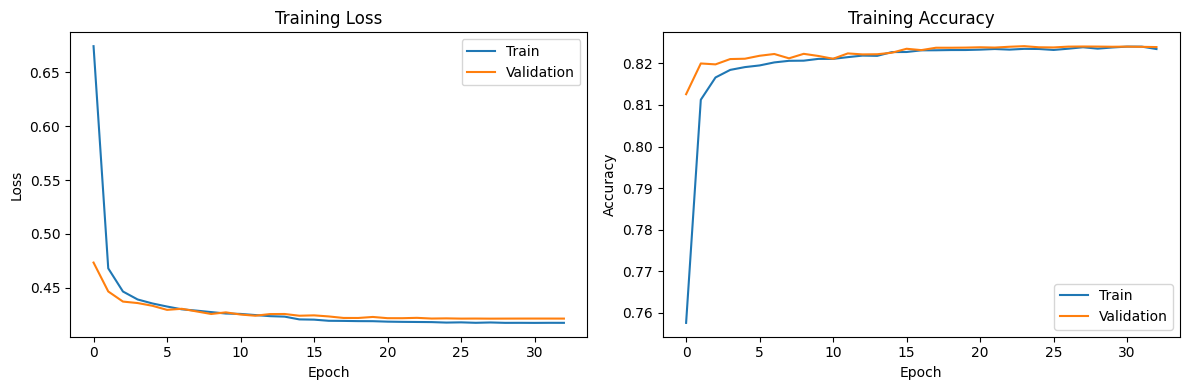

In [8]:
# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        f'{WORK_DIR}/models/checkpoint.keras',
        monitor='val_loss',
        save_best_only=True,
    ),
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
)

# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Training Loss')

axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Training Accuracy')

plt.tight_layout()
plt.savefig(f'{WORK_DIR}/models/training_history.png')
plt.show()

## 6. Evaluation


In [15]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

# Test probabilistic sampling
def predict_next_activity(model, prefix_indices, vocab, temperature=1.0):
    """Predict next activity with probabilistic sampling."""
    # Pad prefix
    pad_idx = vocab['activity_to_idx']['<PAD>']
    max_len = model.input_shape[1]

    if len(prefix_indices) < max_len:
        padded = [pad_idx] * (max_len - len(prefix_indices)) + prefix_indices
    else:
        padded = prefix_indices[-max_len:]

    # Predict
    probs = model.predict(np.array([padded]), verbose=0)[0]

    # Apply temperature
    if temperature != 1.0:
        probs = np.power(probs, 1/temperature)
        probs = probs / probs.sum()

    # Sample
    next_idx = np.random.choice(len(probs), p=probs)
    next_activity = vocab['idx_to_activity'][str(next_idx)]

    return next_activity, probs[next_idx]

# Test on a few examples
print("\nSample predictions:")
test_prefixes = [
    ['A_Create Application'],
    ['A_Create Application', 'A_Submitted'],
    ['A_Create Application', 'A_Submitted', 'W_Handle leads'],
]

with open(vocab_path, 'r') as f:
    vocab = json.load(f)

for prefix in test_prefixes:
    prefix_indices = [vocab['activity_to_idx'][act] for act in prefix]
    next_act, prob = predict_next_activity(model, prefix_indices, vocab)
    print(f"  {prefix[-1]} → {next_act} (p={prob:.3f})")

Validation Loss: 0.4213
Validation Accuracy: 0.8240

Sample predictions:
  A_Create Application → A_Concept (p=0.338)
  A_Submitted → A_Concept (p=0.845)
  W_Handle leads → A_Concept (p=1.000)


## 7. Save final model locally

In [10]:
# Save final model
model_path = f'{WORK_DIR}/models/model.keras'
model.save(model_path)
print(f"Saved model to: {model_path}")

# Save configuration
config = {
    'max_seq_len': MAX_SEQ_LEN,
    'vocab_size': vocab_size,
    'embed_dim': 64,
    'num_heads': 4,
    'ff_dim': 128,
    'num_blocks': 2,
    'dropout_rate': 0.1,
    'training_examples': len(X_train),
    'validation_accuracy': float(val_acc),
    'validation_loss': float(val_loss),
}

config_path = f'{WORK_DIR}/models/config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"Saved config to: {config_path}")

# Save training metadata
from datetime import datetime

metadata = {
    'trained_at': datetime.now().isoformat(),
    'dataset': 'BPIC17',
    'tensorflow_version': tf.__version__,
    'final_val_accuracy': float(val_acc),
    'final_val_loss': float(val_loss),
    'epochs_trained': len(history.history['loss']),
    'training_cases': len(train_cases),
    'validation_cases': len(val_cases),
}

metadata_path = f'{WORK_DIR}/models/training_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata to: {metadata_path}")

Saved model to: /content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer/models/model.keras
Saved config to: /content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer/models/config.json
Saved metadata to: /content/drive/MyDrive/uni/2026_bpso/BPIC17_ProcessTransformer/models/training_metadata.json


## 8. Export to HuggingFace

In [14]:
from huggingface_hub import HfApi, login, create_repo

# Login to HuggingFace (you'll need to enter your token)
login()

# Repository settings
REPO_NAME = "bpic17-process-transformer_v1"
REPO_ID = f"lgk03/{REPO_NAME}"  # Change to your username!

# Create repository (if it doesn't exist)
try:
    create_repo(REPO_ID, repo_type="model", exist_ok=True)
    print(f"Repository ready: https://huggingface.co/{REPO_ID}")
except Exception as e:
    print(f"Repository may already exist: {e}")

# Upload files
api = HfApi()

files_to_upload = [
    (model_path, "model.keras"),
    (vocab_path, "vocab.json"),
    (config_path, "config.json"),
    (metadata_path, "training_metadata.json"),
]

for local_path, repo_path in files_to_upload:
    api.upload_file(
        path_or_fileobj=local_path,
        path_in_repo=repo_path,
        repo_id=REPO_ID,
        repo_type="model",
    )
    print(f"Uploaded: {repo_path}")

Repository ready: https://huggingface.co/lgk03/bpic17-process-transformer_v1


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...former/models/model.keras:  24%|##3       |  562kB / 2.39MB            

Uploaded: model.keras
Uploaded: vocab.json
Uploaded: config.json
Uploaded: training_metadata.json
